In [1]:
#Imports ---------------------------------------
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

In [2]:
#Reading CSV Files -----------------------------

#This function reads a csv file to import data
def read_csv(filename, centerrow):
    with open(filename, newline='') as file:
        reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)  #converts strings from csv file to floats
        data = list(reader)
    #Loop to append each value in the row to a list
    intensity_list = []
    for i in data[centerrow]:  #corresponds to row through center of the diffraction pattern
        if i == '':
            continue
        else:
            intensity_list.append(i)
    return intensity_list


In [39]:
#Fraunhoffer Circular Aperture Curvefit --------

circular_intensity = read_csv('phy512circular.csv', 559)


#Loop to determine intensity error
yerr = []
intensity = []

#Appending 10 rows of intensity values centered at the row with the maximum intensity to a list
for c in range(555,565):
    i1 = read_csv('phy512circular.csv', c)
    for i in i1:
        intensity.append(i)

#Computing the standard error for each column in the rows of data
for index in range(1600):
    stderr = (np.std([intensity[index], intensity[index+1600], intensity[index+3200], intensity[index+4800], intensity[index+6400], intensity[index+8000], intensity[index+9600], intensity[index+11200], intensity[index+12800], intensity[index+14400]]))/np.sqrt(10)
    yerr.append(stderr)
    

#Theta error
xerr = [0.00036 for i in circular_intensity]
    
    
#Loop to determine viewing angle of each pixel
theta_list = []
for num in range(len(circular_intensity)):
    d = -4.0481 + 0.0044*num  #pixel dimensions: 4.4um x 4.4um; leftmost side of data = -4.048mm
    theta = d/(26.3)          #26.3mm from SP620U camera to circular aperture
    theta_list.append(theta)


#Function for intensity of diffraction pattern for circular aperture; I(theta) = I(0) * (2J1(kasin(theta)) / kasin(theta))^2
#params[0] = I(0), params[1] = k, params[2] = a
def circular_curvefit(params, theta):
    return params[0]*((2*j1(params[1]*params[2]*(10**6)*np.sin(theta-params[4])))/(params[1]*params[2]*(10**6)*np.sin(theta-params[4])))**2 + params[3]

data = RealData(theta_list, circular_intensity)

model = Model(circular_curvefit)

pguess = [3918, 0.01, 0.02, 10, 0.01]            #max intensity I(0), wavenumber k, aperture radius a, intensity offset, theta offset
stpb = np.array([100, 0.01, 0.02, 1, 0.1])  #relative step size wrt input variable errors 
odr = ODR(data, model, pguess, stpb=stpb)
output = odr.run()

print('The best fit max intensity is',str(round(output.beta[0],3)),'+-',str(round(output.sd_beta[0],3)),'W/m^2')
print('The best fit wavenumber is',str(round(output.beta[1],4)),'+-',str(round(output.sd_beta[1],4)),'nm^-1.')
print('The best fit aperture radius is',str(round(output.beta[2],3)),'+-',str(round(output.sd_beta[2],3)),'mm.')
print('The best fit intensity offset is',str(round(output.beta[3],3)),'+-',str(round(output.sd_beta[3],3)),'W/m^2.')
print('The best fit theta offset is',str(round(output.beta[4],3)),'+-',str(round(output.sd_beta[3],3)),'rad.')


The best fit max intensity is 3756.984 +- 4635.148 W/m^2
The best fit wavenumber is 0.0053 +- 0.022 nm^-1.
The best fit aperture radius is 0.027 +- 0.065 mm.
The best fit intensity offset is 88.288 +- 6.038 W/m^2.
The best fit theta offset is 0.001 +- 6.038 rad.


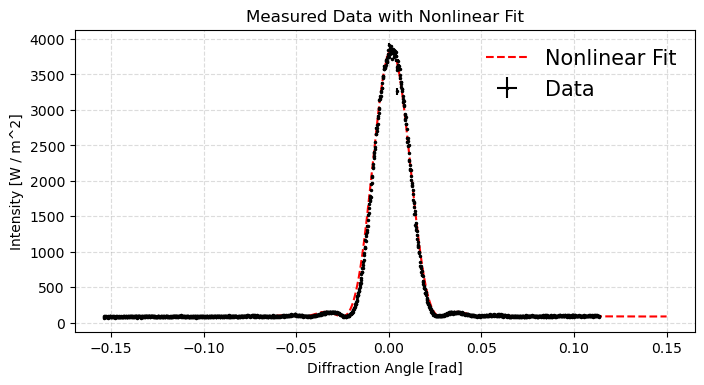

In [40]:
#Plotting Circular Aperture Results ------------

theta_theory = np.linspace(-0.15,0.15,1000)

plt.figure(figsize=(8,4), dpi=100)
plt.errorbar(theta_list, circular_intensity, yerr, xerr, linestyle='None', markersize=3, capsize=0.01, fmt='k.', label='Data')
plt.plot(theta_theory, circular_curvefit(output.beta, theta_theory), linestyle='dashed', color='red', label='Nonlinear Fit')
plt.grid(True, alpha=0.4, linestyle='dashed', color='darkgray')
plt.xlabel('Diffraction Angle [rad]')
plt.ylabel('Intensity [W / m^2]')
plt.title('Measured Data with Nonlinear Fit')
plt.legend(prop={'size':15}, frameon=False)
plt.rcParams['legend.loc'] = 'upper right'
plt.show()

In [5]:
#Fresnel Straight Edge Aperture Curvefit -------

straightedge_intensity = read_csv('phy512straightedge.csv', 882)


#Loop to determine viewing angle of each pixel
screen_list = []
for num in range(len(straightedge_intensity)):
    d = -3 + 0.0044*num  #pixel dimensions: 4.4um x 4.4um; leftmost side of data = -4.048mme
    screen_list.append(d)


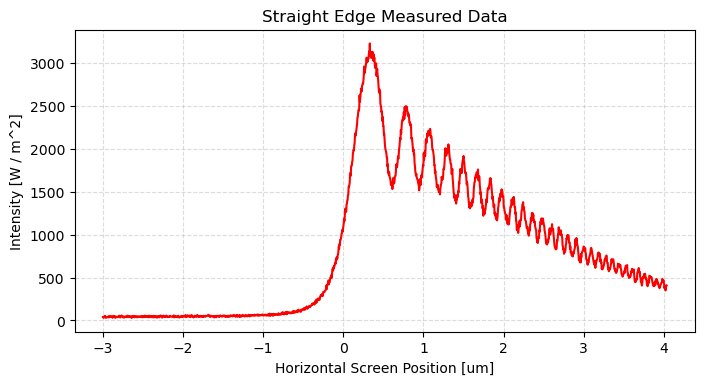

In [6]:
#Plotting Straight Edge Results ----------------
plt.figure(figsize=(8,4), dpi=100)
plt.plot(screen_list, straightedge_intensity, linestyle='solid', color='red', label='Measured Data')
plt.grid(True, alpha=0.4, linestyle='dashed', color='darkgray')
plt.xlabel('Horizontal Screen Position [um]')
plt.ylabel('Intensity [W / m^2]')
plt.title('Straight Edge Measured Data')
plt.show()